<a href="https://colab.research.google.com/github/Yukkitsune/TBank-Analytics/blob/main/Machine%20learning/Trees_and_ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Контекст
Вы работаете в отделе безопасности крупного банка. Перед вами стоит критически важная задача: разработать систему обнаружения мошеннических операций по кредитным картам в реальном времени. Для этого вам предоставили анонимизированный датасет транзакций.

Датасет: [Credit Card Fraud Detection]( https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, StackingClassifier

from sklearn.metrics import f1_score, precision_recall_curve, classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score

https://drive.google.com/file/d/1sh0P2nXA-18hK7RbBCc3qtB6yu79DsvL/view?usp=sharing

In [ ]:
! gdown 1sh0P2nXA-18hK7RbBCc3qtB6yu79DsvL  -q

In [ ]:
CREDIT_CARD = './creditcard.csv'
df = pd.read_csv(CREDIT_CARD, sep=',')

Постановка задачи
Проведите сравнительный анализ алгоритмов машинного обучения для задачи бинарной классификации транзакций на:

Легальные (Class = 0)

Мошеннические (Class = 1)

# Задача 1. Предобработка данных (1 балл)

- Изучите распределение целевой переменной (анализ дисбаланса классов). Постройте графики

- Проведите масштабирование признаков (V1-V28 уже нормализованы, но Time и Amount требуют обработки)

- Разделите данные на обучающую и тестовую выборки (учтите стратификацию из-за дисбаланса)

In [ ]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [ ]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


**Изучите распределение целевой переменной (анализ дисбаланса классов). Постройте графики**

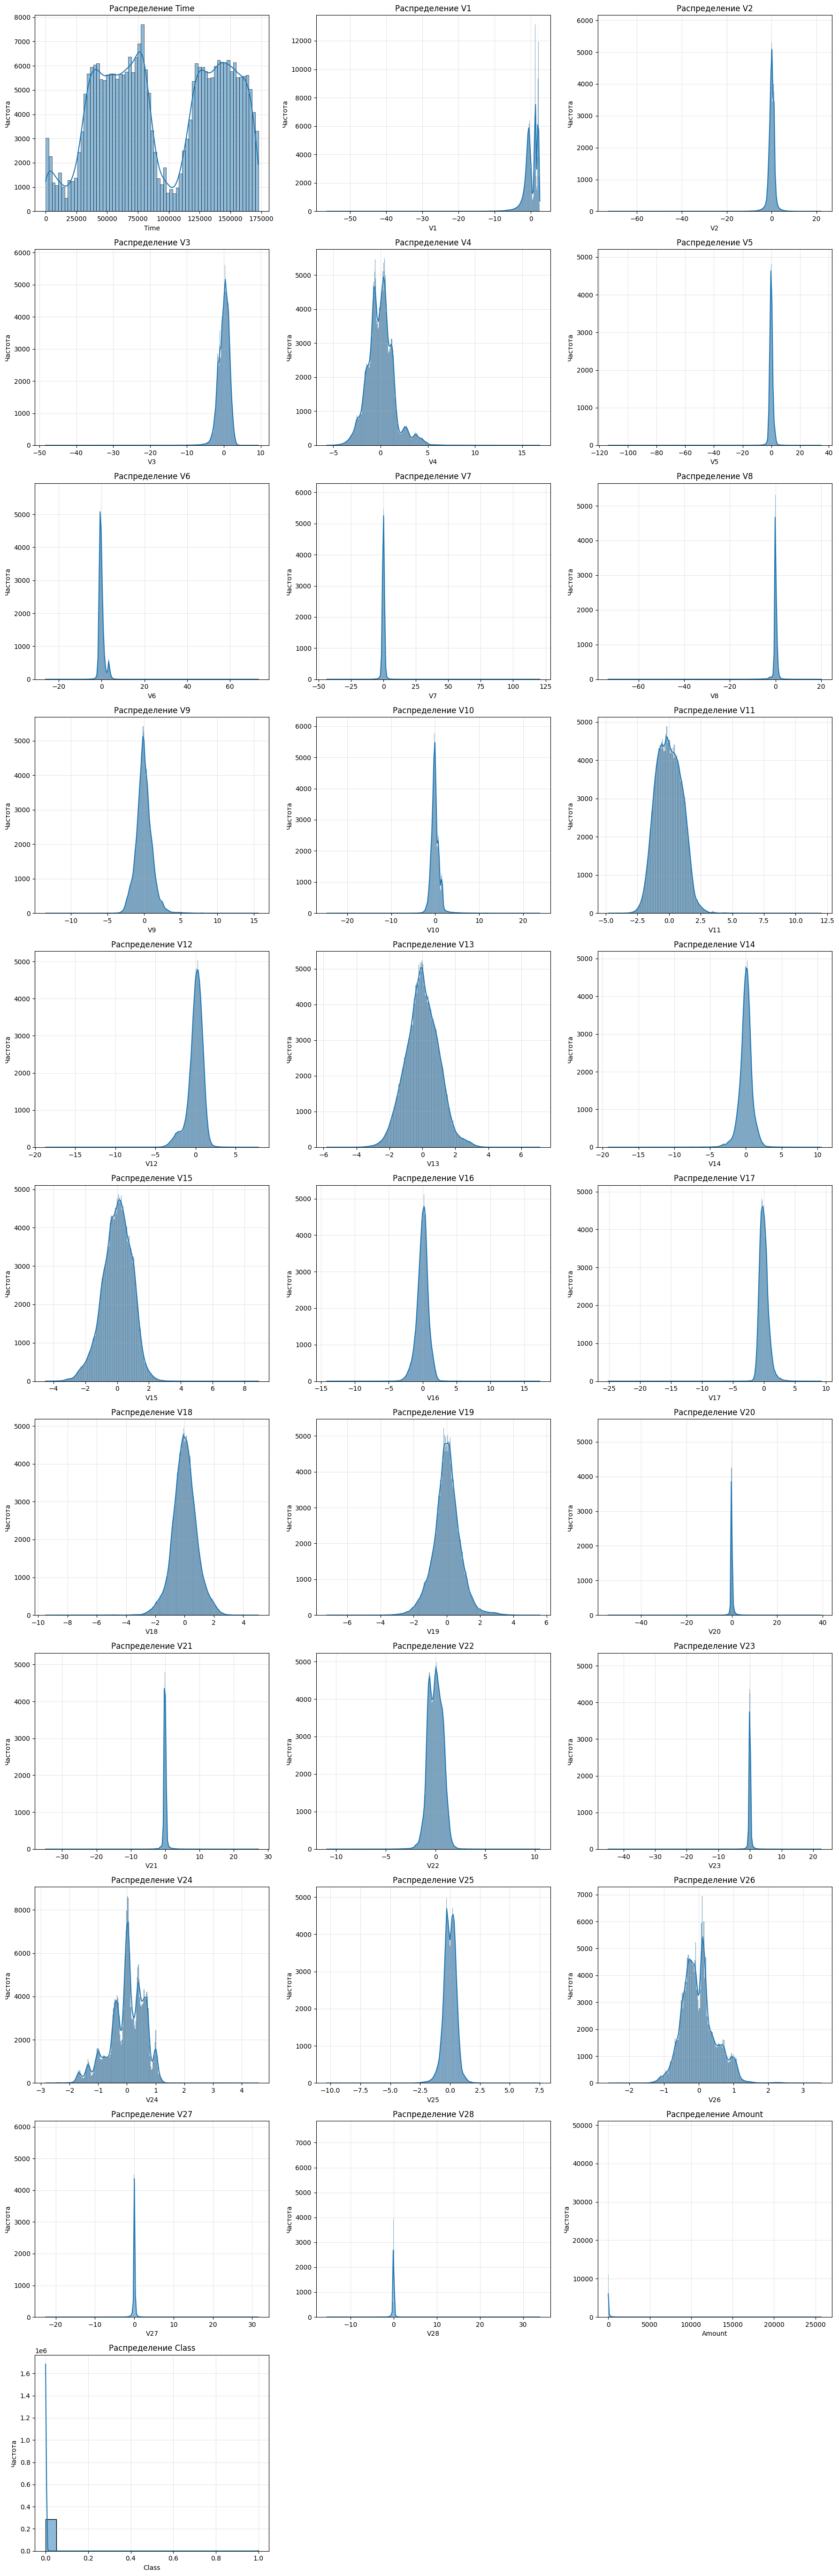

In [ ]:
# Изучим распределение всех фичей
num_cols = df.shape[1]
num_rows = (num_cols + 2) // 3

plt.figure(figsize=(18, 5*num_rows))
for i, column in enumerate(df.columns):
  plt.subplot(num_rows, 3, i + 1)
  sns.histplot(df[column], kde=True)
  plt.title(f'Распределение {column}')
  plt.xlabel(column)
  plt.ylabel('Частота')
  plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

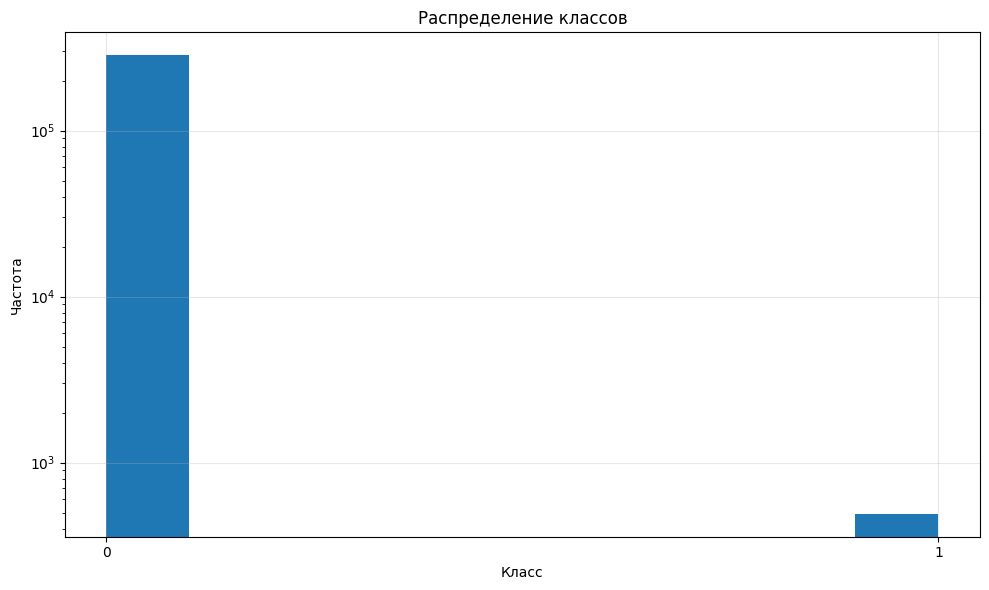

In [ ]:
# Распределение таргета
plt.figure(figsize=(10, 6))
plt.hist(df['Class'])
plt.yscale('log')
plt.xticks([0, 1])
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
class_balance = df.groupby('Class')['Amount'].count()
print('Распределение величин по соответствующим классам')
class_balance

Распределение величин по соответствующим классам


Class
0    284315
1       492
Name: Amount, dtype: int64

In [ ]:
print(f'Класс 0 составляет {class_balance[0] / len(df) * 100}% от датасета')
print(f'Класс 1 составляет {class_balance[1] / len(df) * 100}% от датасета')

Класс 0 составляет 99.82725143693798% от датасета
Класс 1 составляет 0.1727485630620034% от датасета


**Проведите масштабирование признаков (V1-V28 уже нормализованы, но Time и Amount требуют обработки)**

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
def scale_df(df: pd.DataFrame,
             scaler,
             columns: list = None) -> pd.DataFrame:
  scaled_df = df.copy()
  if columns is None:
    columns = scaled_df.select_dtypes(include=[np.number]).columns.tolist()
  scaled_data = scaler.fit_transform(scaled_df[columns])
  scaled_data = pd.DataFrame(scaled_data, columns=columns, index=scaled_df.index)
  scaled_df = scaled_df.drop(columns=columns).join(scaled_data)
  return scaled_df

In [ ]:
scaler = StandardScaler()
df = scale_df(df, scaler, columns=['Time','Amount'])
df.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Time,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,-1.996583,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-1.996583,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,-1.996562,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,-1.996562,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-1.996541,-0.073403
5,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,0,-1.996541,-0.338556
6,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,0,-1.996499,-0.333279
7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0,-1.996436,-0.190107
8,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0,-1.996436,0.019392
9,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,0,-1.996394,-0.338516


**Разделите данные на обучающую и тестовую выборки (учтите стратификацию из-за дисбаланса)**

In [ ]:
y = df['Class']
X = df.drop('Class', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (227845, 30)
Shape of X_test: (56962, 30)
Shape of y_train: (227845,)
Shape of y_test: (56962,)


Видим, что стратификация прошла успешно

In [ ]:
print('Обучающая выборка')
print(f'Класс 0 составляет {y_train[y_train == 0].count() / len(y_train) * 100}% от датасета')
print(f'Класс 1 составляет {y_train[y_train == 1].count() / len(y_train) * 100}% от датасета\n')

print('Валидационная выборка')
print(f'Класс 0 составляет {y_test[y_test == 0].count() / len(y_test) * 100}% от датасета')
print(f'Класс 1 составляет {y_test[y_test == 1].count() / len(y_test) * 100}% от датасета')

Обучающая выборка
Класс 0 составляет 99.82707542408215% от датасета
Класс 1 составляет 0.17292457591783889% от датасета

Валидационная выборка
Класс 0 составляет 99.82795547909133% от датасета
Класс 1 составляет 0.17204452090867595% от датасета


# Задача 2. Построение   моделей ( 2 балла)

Реализуйте следующие алгоритмы:

Базовые модели:

- Линейная регрессия (с пороговой функцией)

- kNN (k-ближайших соседей)

- Решающее дерево

Ансамблевые методы:

- Бэггинг (BaggingClassifier)

- Случайный лес (Random Forest)

- Стекинг (StackingClassifier) для моделей

  *   LogisticRegression,
  *  KNeighborsClassifier,
  *  DecisionTreeClassifier


Может долго работать, но примерно до 15-20 минут !

Для того, чтобы корректно сравнивать модели между собой, для каждой из них попытаемся определить оптимальные по f1_score параметры. В дальнейших заданиях после выбора лучшей модели уже можно будет подобрать их корректнее

## **Линейная регрессия (с пороговой функцией)**

В начале решения задания пользовался логистической регрессией с порогом, так как подумал, что тут опечатка - не слышал, чтобы линейной регрессией пользовались для классификации, но на последней лекции преподаватель подтвердил, что тут нужна именно линейная регрессия -> переделал под неё.

In [ ]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

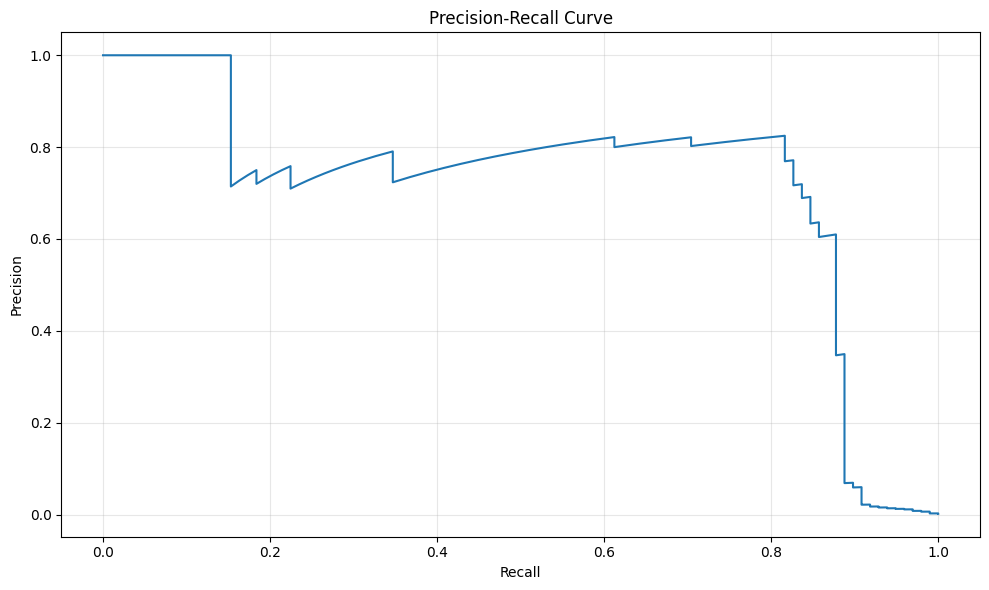

In [ ]:
# Построим Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)

plt.figure(figsize=(10,6))
plt.plot(recalls, precisions)
plt.title('Precision-Recall Curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
def get_best_threshold(y_test: pd.DataFrame, y_prob: list, steps: int = 300):
  thresholds = np.linspace(y_pred.min(), y_pred.max(), steps)
  max_f1, max_threshold = 0, thresholds[0]

  for threshold in thresholds:
    pred = (y_prob >= threshold).astype(int)
    f1 = f1_score(y_test, pred)
    if f1 > max_f1:
      max_f1 = f1
      max_threshold = threshold
  return max_threshold

In [ ]:
max_threshold = get_best_threshold(y_test, y_pred)
print(f'Max threshold -> {max_threshold}')

Max threshold -> 0.22895584312484357


In [ ]:
y_pred_reg = (y_pred >= max_threshold).astype(int)
reg_f1 = f1_score(y_test, y_pred_reg)
print(f'Linear Regression f1_score -> {reg_f1}')

Linear Regression f1_score -> 0.8205128205128205


In [ ]:
print(f'Classification report:\n{classification_report(y_test,y_pred_reg)}')
print(f'Confusion matrix:\n{confusion_matrix(y_test, y_pred_reg)}')

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.82      0.82        98

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Confusion matrix:
[[56847    17]
 [   18    80]]


## **kNN (k-ближайших соседей)**

При подборе оптимального количества соседей разобьем трейны на трейн и валидацию

In [ ]:
def get_best_k(X_train: pd.DataFrame, y_train: pd.DataFrame, min_k: int = 1, max_k: int = 20):
  X_tra, X_val, y_tra, y_val = train_test_split(
      X_train,
      y_train,
      test_size=0.2,
      random_state=42,
      stratify=y_train
  )
  ks = np.arange(min_k, max_k)
  best_score = 0
  best_k = 0
  for k in tqdm(ks):
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_tra, y_tra)
    y_pred = knn.predict(X_val)
    score = f1_score(y_val, y_pred)
    if score > best_score:
      best_score = score
      best_k = k
  return best_k

In [ ]:
best_k = get_best_k(X_train, y_train)

100%|██████████| 19/19 [02:26<00:00,  7.72s/it]


In [ ]:
knn = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
knn_f1 = f1_score(y_test, y_pred_knn)

In [ ]:
print(f'K Nearest Neighbors f1_score -> {knn_f1}')
print(f'Best K -> {best_k}')

K Nearest Neighbors f1_score -> 0.7955801104972375
Best K -> 11


In [ ]:
print(f'Classification report:\n {classification_report(y_test, y_pred_knn)}')

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.73      0.80        98

    accuracy                           1.00     56962
   macro avg       0.93      0.87      0.90     56962
weighted avg       1.00      1.00      1.00     56962



## Решающее дерево

Так как для решающего дерева слишком много параметров сильно влияют на результат, воспользуемся GridSearchCV для удобства их подбора вместо использования обычного перебора в цикле, кроме того немного уменьшим трейн для сокращения времени подбора

In [ ]:
def get_best_decision_tree_params(X_train: pd.DataFrame, y_train: pd.DataFrame):
  params = {
      'max_depth' : [3, 5, 7, 9],
      'min_samples_split' : [3, 5, 10, 20],
      'min_samples_leaf' : [1, 3, 5, 10],
    }
  decision_tree = DecisionTreeClassifier(random_state=42)
  grid_tree = GridSearchCV(
      decision_tree,
      params,
      scoring='f1',
      cv=3,
      n_jobs=-1
    )
  grid_tree.fit(X_train, y_train)
  return grid_tree.best_params_

In [ ]:
best_decision_tree_params = get_best_decision_tree_params(X_train, y_train)

In [ ]:
print(f'Best Decision Tree params -> {best_decision_tree_params}')

Best Decision Tree params -> {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 3}


In [ ]:
decision_tree = DecisionTreeClassifier(
    **best_decision_tree_params,
    random_state=42
)
decision_tree.fit(X_train, y_train)
y_pred_dt = decision_tree.predict(X_test)
dt_f1 = f1_score(y_test, y_pred_dt)

In [ ]:
print(f'Decision tree f1_score -> {dt_f1}')

Decision tree f1_score -> 0.7909604519774012


In [ ]:
print(f'Classification report:\n {classification_report(y_test, y_pred_dt)}')

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.71      0.79        98

    accuracy                           1.00     56962
   macro avg       0.94      0.86      0.90     56962
weighted avg       1.00      1.00      1.00     56962



## Бэггинг (BaggingClassifier)

In [ ]:
def get_best_estimators(best_dt_params: dict, X_train, y_train):
  X_tra, X_val, y_tra, y_val = train_test_split(
      X_train,
      y_train,
      test_size=0.2,
      random_state=42,
      stratify=y_train
  )
  best_f1 = 0
  best_est = 0
  estimators = [20, 30, 40, 50, 70, 100]
  for n in tqdm(estimators):
    bagging = BaggingClassifier(
        estimator=DecisionTreeClassifier(
            **best_dt_params,
            random_state=42
        ),
        n_estimators=n,
        random_state=42,
        n_jobs=-1
    )
    bagging.fit(X_tra, y_tra)
    y_pred = bagging.predict(X_val)
    score = f1_score(y_val, y_pred)
    if score > best_f1:
      best_f1 = score
      best_est = n
  return best_est

In [ ]:
best_nest = get_best_estimators(best_decision_tree_params, X_train, y_train)

100%|██████████| 6/6 [03:28<00:00, 34.81s/it]


In [ ]:
bagging_tree = BaggingClassifier(
    estimator=DecisionTreeClassifier(
            **best_decision_tree_params,
            random_state=42
        ),
        n_estimators=best_nest,
        random_state=42,
        n_jobs=-1
)
bagging_tree.fit(X_train, y_train)
y_pred_bt = bagging_tree.predict(X_test)
bt_f1 = f1_score(y_test, y_pred_bt)

In [ ]:
print(f'Bagging f1_score -> {bt_f1}')

Bagging f1_score -> 0.8817204301075269


In [ ]:
print(f'Classification report:\n {classification_report(y_test, y_pred_bt)}')

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.84      0.88        98

    accuracy                           1.00     56962
   macro avg       0.97      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962



## Случайный лес (Random Forest)

In [ ]:
def get_best_forest_params(best_dt_params: dict, X_train: pd.DataFrame, y_train: pd.DataFrame):
  X_tra, X_val, y_tra, y_val = train_test_split(
      X_train,
      y_train,
      test_size=0.2,
      random_state=42,
      stratify=y_train
  )
  best_f1 = 0
  best_est = 0
  estimators = [100, 150, 200, 250, 300]
  for n in tqdm(estimators):
    forest = RandomForestClassifier(
        n_estimators=n,
        random_state=42,
        n_jobs=-1,
        **best_dt_params
    )
    forest.fit(X_tra, y_tra)
    y_pred = forest.predict(X_val)
    score = f1_score(y_val, y_pred)
    if score > best_f1:
      best_f1 = score
      best_est = n
  return best_est

In [ ]:
best_random_forest_params = get_best_forest_params(best_decision_tree_params,X_train, y_train)

100%|██████████| 5/5 [01:51<00:00, 22.35s/it]


In [ ]:
random_forest = RandomForestClassifier(
    n_estimators=best_random_forest_params,
    random_state=42,
    n_jobs=-1,
    **best_decision_tree_params
)
random_forest.fit(X_train, y_train)
y_pred_rf = bagging_tree.predict(X_test)
rf_f1 = f1_score(y_test, y_pred_rf)

In [ ]:
print(f'Random forest f1_score -> {rf_f1}')

Random forest f1_score -> 0.8817204301075269


In [ ]:
print(f'Classification report:\n {classification_report(y_test, y_pred_rf)}')

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.84      0.88        98

    accuracy                           1.00     56962
   macro avg       0.97      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962



## Стекинг (StackingClassifier) для моделей

LogisticRegression,
KNeighborsClassifier,
DecisionTreeClassifier

In [ ]:
stacking = StackingClassifier(
    estimators=[
        ('linear_reg', reg),
        ('knn', knn),
        ('decision_tree', decision_tree)
    ],
    final_estimator=LogisticRegression(
        random_state=42,
        max_iter=1000,
    ),
    cv=3,
    n_jobs=-1
)
stacking.fit(X_train, y_train)
y_prob_st = stacking.predict_proba(X_test)[:, 1]
stacking_threshold = get_best_threshold(y_test, y_prob_st)
y_pred_st = (y_prob_st >= stacking_threshold).astype(int)
st_f1 = f1_score(y_test, y_pred_st)

In [ ]:
print(f'Stacking f1_score -> {st_f1}')

Stacking f1_score -> 0.8526315789473684


In [ ]:
print(f'Classification report:\n {classification_report(y_test, y_pred_st)}')

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.83      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



# Задача 3. Оценка моделей ( 2 балла )

Для каждой модели рассчитайте:

- Precision и Recall

- F1-score (основная метрика из-за дисбаланса)

- ROC-AUC

- Матрицу ошибок (Confusion Matrix)

Подсказка: Мы оцениваем на тестовой выборке

Базовые модели:

- Линейная регрессия (с пороговой функцией)

- kNN (k-ближайших соседей)

- Решающее дерево

Ансамблевые методы:

- Бэггинг (BaggingClassifier)

- Случайный лес (Random Forest)

- Стекинг (StackingClassifier) для моделей

In [ ]:
def get_metrics(models_pred: dict, y_true: list) -> pd.DataFrame:
    scores = []
    for name, pred in models_pred.items():
        precision = precision_score(y_true, pred)
        recall = recall_score(y_true, pred)
        f1 = f1_score(y_true, pred)
        roc_auc = roc_auc_score(y_true, pred)
        confusion = confusion_matrix(y_true, pred)
        tn, fp, fn, tp = confusion.ravel()
        scores.append({
            'Model Name' : name,
            'Precision Score' : precision,
            'Recall Score' : recall,
            'F1 Score' : f1,
            'ROC AUC Score' : roc_auc,
            'TN' : tn,
            'FP' : fp,
            'FN' : fn,
            'TP' : tp
        })
    df = pd.DataFrame(scores)
    return df.sort_values('F1 Score', ascending=False)

In [ ]:
model_pred = {
    'Linear Regression' : y_pred_reg,
    'K Nearest Neighbors' : y_pred_knn,
    'Decision Tree' : y_pred_dt,
    'Bagging' : y_pred_bt,
    'Random Forest' : y_pred_rf,
    'Stacking' : y_pred_st
}

In [ ]:
models_metrics = get_metrics(model_pred, y_test)
models_metrics

,Model Name,Precision Score,Recall Score,F1 Score,ROC AUC Score,TN,FP,FN,TP
4,Random Forest,0.931818,0.836735,0.881720,0.918315,56858,6,16,82
3,Bagging,0.931818,0.836735,0.881720,0.918315,56858,6,16,82
5,Stacking,0.880435,0.826531,0.852632,0.913169,56853,11,17,81
0,Linear Regression,0.824742,0.816327,0.820513,0.908014,56847,17,18,80
1,K Nearest Neighbors,0.867470,0.734694,0.795580,0.867250,56853,11,26,72
2,Decision Tree,0.886076,0.714286,0.790960,0.857064,56855,9,28,70


Выводы:

Ожидаемо наилучшие результаты показали ансамблевые модели. Среди них Random Forest и Bagging получили одинаково высокие оценки с f1 score = 0.88 и roc auc score = 0.92, при этом еще лучше понять качество моделей помогает confusion matrix - модели верно определили практически 57 тысяч наблюдений, а ошиблись всего в 22 случаях. Незначительно по качеству уступает Stacking, который, хоть и является более сложной моделью, так как совмещает в себе несколько отдельных моделей, не смог превзойти более простые ансамбли.

Далее по качеству расположились базовые модели, в которых лидирует линейная регрессия с оптимальным порогом. Последние места заняли KNN и решающее дерево, которые уже не так хорошо справились с большим различием количества экземпляров каждого из классов во время обучения. Они имеют показатели Precision Score близкие к ансамблям, но Recall является наихудшим среди всех обученных моделей. В общем ни одна из моделей не является очень плохой -> лучше выбирать по ситуации.

В контексте обнаружения мошеннических операций и Precision, и Recall важны, но Precision всё же имеет немного больший приоритет, так как вряд ли обычные клиенты будут довольны, если банк заблокирует их счета, следовательно они могут уйти. Так на 6 ложных положительных случаев случайного леса и беггинга имеем 28 срабатываний решающего дерева, что играет огромную роль в оценке качества моделей.

# Задача 4. Сравнительный анализ ( 1 балл)

Создайте сводную таблицу со всеми метриками и проведите анализ:

- Какая модель показывает наилучшее качество?

- Какие модели лучше обнаруживают мошеннические транзакции (высокий recall)?

- Какие модели минимизируют ложные срабатывания (высокий precision)?

In [ ]:
models_metrics

,Model Name,Precision Score,Recall Score,F1 Score,ROC AUC Score,TN,FP,FN,TP
4,Random Forest,0.931818,0.836735,0.881720,0.918315,56858,6,16,82
3,Bagging,0.931818,0.836735,0.881720,0.918315,56858,6,16,82
5,Stacking,0.880435,0.826531,0.852632,0.913169,56853,11,17,81
0,Linear Regression,0.824742,0.816327,0.820513,0.908014,56847,17,18,80
1,K Nearest Neighbors,0.867470,0.734694,0.795580,0.867250,56853,11,26,72
2,Decision Tree,0.886076,0.714286,0.790960,0.857064,56855,9,28,70


Ответы:

Наилучшее качество - необходим баланс между высокими Precision и Recall, то есть F1 Score, которые показывают ансамблевые модели, лучшими из которых являются Random Forest и Bagging.

Высокий Recall - наиболее высокий recall показывают ансамблевые модели и линейная регрессия. В процессе построения модели регрессии мы выбирали оптимальный порог для более точной классификации - в итоге получили 0.22.

Высокий Precision - высший precision имеет stacking, так как сочетает в себе несколько базовых моделей, финальный классификатор учится на предсказаниях остальных моделей, в результате чего ошибка усредняется. Далее идет Random Forest - состоит из независимых решающих деревьев, каждое из которых тренируется на своих собственных случайно выбираемых признаках, кроме того используется bootstrap - в результате получаем хорошую модель, которая редко ошибается. Bagging так же имеет высокий precision - обучает много деревьев на бутстрапированных выборках и усредняет ответ. Благодаря этому получаем очень низкий разброс и высокое попадание в таргет. Decision tree так же хорош по описанным в прошлом задании причинам, из-за этого получаем высокий precision.

# Задача 5. Углубленный анализ ошибок ( 2 балла)
- Проанализируйте ложно-положительные и ложно-отрицательные случаи лучшей модели

- Определите паттерны в транзакциях, которые модель классифицирует неправильно

- Визуализируйте распределение ошибок по признакам Amount и Time

Из таблицы метрик видим, что наилучшими моделями являются Bagging и Random Forest, но из-за более комплексного процесса обучения, лучшим будет Random Forest - обучается с помощью беггинга и метода случайных подпространств одновременно

In [ ]:
models_metrics

,Model Name,Precision Score,Recall Score,F1 Score,ROC AUC Score,TN,FP,FN,TP
4,Random Forest,0.931818,0.836735,0.881720,0.918315,56858,6,16,82
3,Bagging,0.931818,0.836735,0.881720,0.918315,56858,6,16,82
5,Stacking,0.880435,0.826531,0.852632,0.913169,56853,11,17,81
0,Linear Regression,0.824742,0.816327,0.820513,0.908014,56847,17,18,80
1,K Nearest Neighbors,0.867470,0.734694,0.795580,0.867250,56853,11,26,72
2,Decision Tree,0.886076,0.714286,0.790960,0.857064,56855,9,28,70


In [ ]:
def confusion_class(row):
    if row['True Class'] == 0 and row['Random Forest Predicted'] == 0:
        return 'TN'
    elif row['True Class'] == 0 and row['Random Forest Predicted'] == 1:
        return 'FP'
    elif row['True Class'] == 1 and row['Random Forest Predicted'] == 0:
        return 'FN'
    else:
        return 'TP'

In [ ]:
test_df = X_test.copy()
test_df['True Class'] = y_test.values
test_df['Random Forest Predicted'] = y_pred_rf
test_df['Confusion'] = test_df.apply(confusion_class, axis=1)
test_df['Random Forest Probabilities'] = random_forest.predict_proba(X_test)[:, 1]

In [ ]:
error_df = test_df[(test_df['Confusion'] == 'FN') | (test_df['Confusion'] == 'FP')]
v_cols = [col for col in error_df.columns if col.startswith('V')]
error_df['V_mean'] = error_df[v_cols].mean(axis=1)
error_df.head(10)

C:\Users\akito\AppData\Local\Temp\ipykernel_20872\2525407596.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['V_mean'] = error_df[v_cols].mean(axis=1)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V26,V27,V28,Time,Amount,True Class,Random Forest Predicted,Confusion,Random Forest Probabilities,V_mean
190263,-1.272117,1.827615,-3.810610,0.583759,-0.641242,-1.389043,-1.954054,1.173920,-2.053191,-3.345061,...,0.534870,0.183562,0.020316,0.714814,-0.350191,0,1,FP,0.500735,-0.837903
14920,-17.950631,11.067069,-20.742660,6.075531,-13.389765,-4.532888,-15.188146,12.101062,-4.026880,-9.017413,...,-0.238730,1.554463,0.547948,-1.444507,-0.349231,0,1,FP,0.863491,-3.129598
9643,0.526768,0.314305,-0.497534,0.959570,-1.625545,-0.367521,-2.374770,0.556905,0.829738,-2.311119,...,1.075946,0.301438,0.171752,-1.692380,-0.197304,0,1,FP,0.380182,-0.334264
14170,-15.903635,10.393917,-19.133602,6.185969,-12.538021,-4.027030,-13.897827,10.662252,-2.844954,-9.668789,...,-0.273743,1.688136,0.527831,-1.465965,0.046539,1,0,FN,0.269100,-2.986350
153398,-2.690251,1.465266,-0.691844,4.322855,-1.086880,0.063585,-2.966872,-0.059646,-0.090827,-1.291980,...,-0.044074,0.005614,0.557189,0.086130,-0.353229,0,1,FP,0.558252,-0.747457
50537,-0.234922,0.355413,1.972183,-1.255593,-0.681387,-0.665732,0.059110,-0.003153,1.122451,-1.481246,...,-0.531846,0.123185,0.039581,-1.058832,-0.349231,1,0,FN,0.000235,0.081558
157585,1.934946,0.650678,-0.286957,3.987828,0.316052,-0.099449,-0.021483,-0.172327,0.508730,1.072955,...,-0.129954,-0.050077,-0.051082,0.321621,-0.349231,1,0,FN,0.000861,0.156202
623,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,-0.145362,-0.252773,0.035764,-1.986644,1.761758,1,0,FN,0.000633,0.148612
96341,1.227614,-0.668974,-0.271785,-0.589440,-0.604795,-0.350285,-0.486365,-0.010809,-0.794944,0.264545,...,-0.283738,-0.001128,0.035075,-0.612488,0.038623,1,0,FN,0.000262,-0.035127
68067,-1.101847,-1.632441,0.901067,0.847753,-1.249091,0.654937,1.448868,0.023308,-0.136742,-0.150129,...,0.699175,-0.336072,-0.177587,-0.884430,1.725376,1,0,FN,0.000430,0.169508


- Проанализируйте ложно-положительные и ложно-отрицательные случаи лучшей модели

- Определите паттерны в транзакциях, которые модель классифицирует неправильно

In [ ]:
error_df.groupby('Confusion').agg(
    avg_prob=('Random Forest Probabilities', 'mean'),
    avg_time=('Time', 'mean'),
    avg_amount=('Amount', 'mean'),
    avg_v=('V_mean', 'mean')
)

,avg_prob,avg_time,avg_amount,avg_v
Confusion,,,,
FN,0.087920,-0.478146,0.197337,-0.199519
FP,0.611911,-0.535963,-0.324890,-1.406237


На основании средних показателей величин можно сделать следующие выводы:

FP: модель определяет операции как мошеннические, если они сделаны в раннее время по датафрейму, имеют низкую сумму, а так же крайне низкие признаки V - по таблице видно, что от FN показатели V отличаются в 7 раз. Таким операциям модель выдает среднюю вероятность

FN: модель ошибочно определяет операции как обычные, если они сделаны раньше по датафрейму, имеют большие суммы и признаки V намного ниже, чем для FP. В таких операциях модель очень не уверена

Визуализируйте распределение ошибок по признакам Amount и Time

In [ ]:
def get_dist(df: pd.DataFrame, error_type: str, features: list = ['Amount', 'Time']):
    num_cols = len(features)
    plt.figure(figsize=(5*num_cols, 4))
    for i, column in enumerate(features):
        plt.subplot(1, num_cols, i + 1)
        sns.histplot(
            df[df['Confusion'] == error_type][column],
            color='blue', alpha=0.5, label=error_type, stat='density', bins=20
        )
        plt.title(f'Распределение ошибок по {column}')
        plt.xlabel(column)
        plt.ylabel('Частота')
        plt.legend()
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

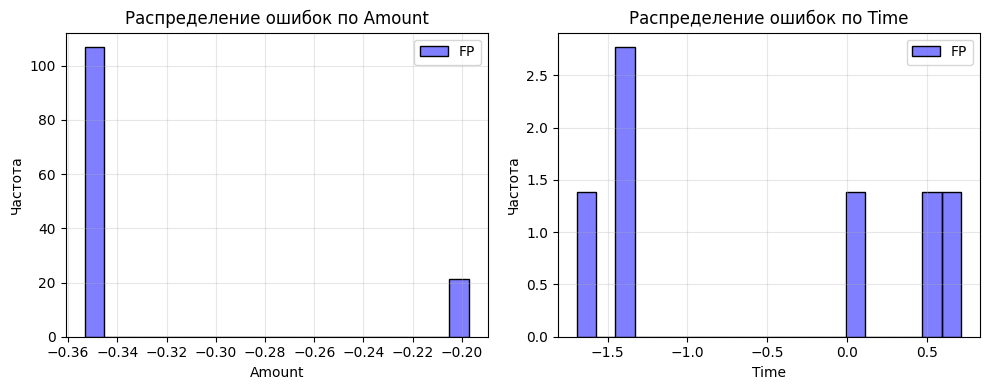

In [ ]:
get_dist(error_df, 'FP')

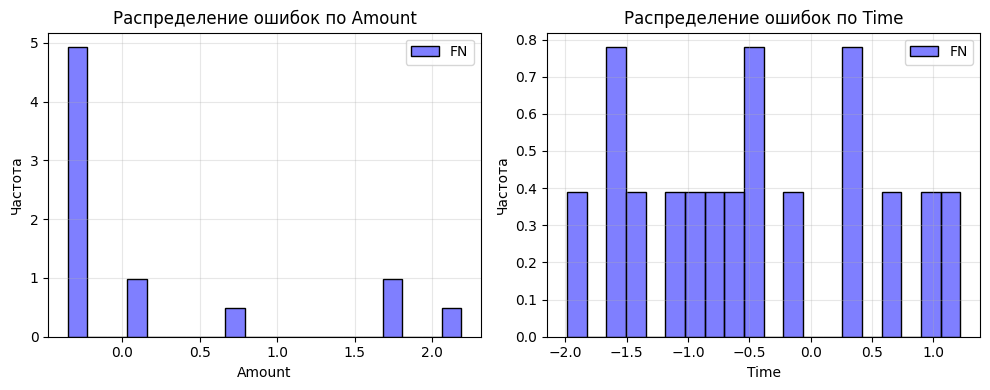

In [ ]:
get_dist(error_df, 'FN')

Из графиков распределений видно, что в основном ошибки модели связаны с очень маленькими суммами транзакций, что опасно, так как при FN происходят равномерно, а значит путем совершения большого числа малых транзакций через примерно одинаковое время можно вывести большое количество средств. FP имеет не такое полноценное распределение по времени, однако оно тоже похоже на равномерное.

# Задача 6. Подбор гиперпараметров (2 балла)

- Подберите оптимальные гиперпараметры с помощью [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) для лучшей модели.
-  Построй модель с лучшими параметрами и оцени
- Напиши выводы о лучшей модели.

In [ ]:
def find_optimal_params_rf(X_train: pd.Series, y_train: pd.Series, cv: int = 2):
    params = {
        'n_estimators' : [300, 350, 400],
        'max_depth' : [10, 13, 15],
        'min_samples_split' : [3, 5, 7, 9],
        'min_samples_leaf': [1, 2, 3],
        'class_weight': [
            None,
            {0: 1, 1: 5},
            {0: 1, 1: 10}
        ]
    }
    random_forest = RandomForestClassifier(random_state=42, n_jobs=6)

    grid_forest = GridSearchCV(
        estimator=random_forest,
        param_grid=params,
        cv=cv,
        scoring='f1',
        n_jobs=1,
        verbose=2
    )
    grid_forest.fit(X_train, y_train)

    return grid_forest.best_params_, grid_forest

In [ ]:
best_rf_params = find_optimal_params_rf(X_train, y_train)

Fitting 2 folds for each of 324 candidates, totalling 648 fits
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=  33.0s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time=  32.9s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=3, n_estimators=350; total time=  38.3s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=3, n_estimators=350; total time=  38.2s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=3, n_estimators=400; total time=  43.7s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=3, n_estimators=400; total time=  43.3s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  33.0s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=3

In [ ]:
# Записал лучшие параметры, чтобы не подбирать еще раз несколько часов
best_rf_params = {
    'class_weight': {0: 1, 1: 5},
    'max_depth': 13,
    'min_samples_leaf': 1,
    'min_samples_split': 9,
    'n_estimators': 400
    }

In [ ]:
print(f'Лучшие параметры для случайного леса ->\n{best_rf_params}')


Лучшие параметры для случайного леса ->
{'class_weight': {0: 1, 1: 5}, 'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 400}


Лучшие параметры для случайного леса  ->
{'class_weight': {0: 1, 1: 5}, 'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 400}

In [ ]:
best_random_forest = RandomForestClassifier(
    random_state=42,
    **best_rf_params
)
best_random_forest.fit(X_train, y_train)
y_pred_best_rf = best_random_forest.predict(X_test)
best_rf_metrics = get_metrics({'Best Random Forest' : y_pred_best_rf}, y_test)

In [ ]:
compare_rfs = pd.concat([models_metrics[models_metrics['Model Name'] == 'Random Forest'], best_rf_metrics], ignore_index=True)
difference = {'Model Name' : 'Difference Best -> Regular'}
for col in compare_rfs.columns:
    if col != 'Model Name':
        difference[col] = compare_rfs.iloc[1][col] - compare_rfs.iloc[0][col]
difference_df = pd.DataFrame([difference])
compare_rfs = pd.concat([compare_rfs, difference_df], ignore_index=True)
compare_rfs

,Model Name,Precision Score,Recall Score,F1 Score,ROC AUC Score,TN,FP,FN,TP
0,Random Forest,0.931818,0.836735,0.881720,0.918315,56858,6,16,82
1,Best Random Forest,0.942529,0.836735,0.886486,0.918323,56859,5,16,82
2,Difference Best -> Regular,0.010711,0.000000,0.004766,0.000009,1,-1,0,0


Выводы:

По итогам подбора гиперпараметров получили модель, которая по f1 score практически не превышает стандартную, а значит мы достигли практически максимального качества, какого можно добиться на этих данных. Любые изменения не принесут большого вклада в F1 Score модели. Recall остался неизменным, Precision увеличился на 1%. В результате изменения этих метрик получили модель, которая меньше ошибается при определении мошеннического класса - на 1 ложное срабатывание меньше -> +1 TN. Итак, засчет снижения FP на 1 у нас получилось немного уменьшить операционные затраты на расследование ложных срабатываний, а так же не потерять одного клиента.